In [13]:
import pandas as pd
import numpy as np
import cv2
# import plotly.express as px
import plotly.graph_objs as go
import hashlib

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

DIR_INPUT = '/data/Dataset/plant-pathology-2020-fgvc7/'

In [7]:
train_df = pd.read_csv(DIR_INPUT + '/train.csv')
train_df.shape

(1821, 5)

In [8]:
train_df.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [9]:
test_df = pd.read_csv(DIR_INPUT + '/test.csv')
test_df.shape

(1821, 1)

In [10]:
test_df.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [11]:
def calculate_hash(im):
    md5 = hashlib.md5()
    md5.update(np.array(im).tostring())
    
    return md5.hexdigest()
    
def get_image_meta(image_id, image_src, dataset='train'):
    im = Image.open(image_src)
    extrema = im.getextrema()

    meta = {
        'image_id': image_id,
        'dataset': dataset,
        'hash': calculate_hash(im),
        'r_min': extrema[0][0],
        'r_max': extrema[0][1],
        'g_min': extrema[1][0],
        'g_max': extrema[1][1],
        'b_min': extrema[2][0],
        'b_max': extrema[2][1],
        'height': im.size[0],
        'width': im.size[1],
        'format': im.format,
        'mode': im.mode
    }
    return meta

In [14]:
data = []

for i, image_id in enumerate(tqdm(train_df['image_id'].values, total=train_df.shape[0])):
    data.append(get_image_meta(image_id, DIR_INPUT + '/images/{}.jpg'.format(image_id)))

100%|██████████| 1821/1821 [04:14<00:00,  7.14it/s]


In [15]:
for i, image_id in enumerate(tqdm(test_df['image_id'].values, total=test_df.shape[0])):
    data.append(get_image_meta(image_id, DIR_INPUT + '/images/{}.jpg'.format(image_id), 'test'))

100%|██████████| 1821/1821 [03:52<00:00,  8.33it/s]


In [16]:
meta_df = pd.DataFrame(data)
meta_df.head()

b_max  b_min dataset format  g_max  g_min  \
0    255      0   train   JPEG    255     14   
1    255      0   train   JPEG    255     22   
2    255      6   train   JPEG    255     34   
3    255      0   train   JPEG    255     26   
4    250      0   train   JPEG    255     46   

                               hash  height image_id mode  r_max  r_min  width  
0  0ed246432c166ea6b26ab531a0e14654    2048  Train_0  RGB    252     15   1365  
1  f2c4f0f0f3574c1722105635fb29d2ff    2048  Train_1  RGB    255     39   1365  
2  1ff49f8cd108961f3313eb8214195386    2048  Train_2  RGB    255     17   1365  
3  855994deab78d03bf29de8746eb84cda    2048  Train_3  RGB    255     18   1365  
4  3b8877a0a32112001c6e405131aab4f3    2048  Train_4  RGB    238     18   1365

In [17]:
meta_df.groupby(by='dataset')[['width', 'height']].aggregate(['min', 'max'])

width       height      
          min   max    min   max
dataset                         
test     1365  2048   1365  2048
train    1365  2048   1365  2048

In [24]:
meta_df['height'].describe(percentiles=[0.005,0.007,0.01,0.1])

count    3642.000000
mean     2043.874245
std        52.930503
min      1365.000000
0.5%     1365.000000
0.7%     2048.000000
1%       2048.000000
10%      2048.000000
50%      2048.000000
max      2048.000000
Name: height, dtype: float64

In [28]:
meta_df['width'].describe(percentiles=[0.1,0.99,0.993,0.995])

count    3642.000000
mean     1369.125755
std        52.930503
min      1365.000000
10%      1365.000000
50%      1365.000000
99%      1365.000000
99.3%    1365.000000
99.5%    2048.000000
max      2048.000000
Name: width, dtype: float64

In [29]:
duplicates = meta_df.groupby(by='hash')[['image_id']].count().reset_index()
duplicates = duplicates[duplicates['image_id'] > 1]
duplicates.reset_index(drop=True, inplace=True)

duplicates = duplicates.merge(meta_df[['image_id', 'hash']], on='hash')

duplicates.head(20)

hash  image_id_x  image_id_y
0  39cdbff63bcd5ec83cbf4e2f6147eb12           2  Train_1703
1  39cdbff63bcd5ec83cbf4e2f6147eb12           2   Test_1407
2  53e14328863405b825081244e44f16b3           2    Test_570
3  53e14328863405b825081244e44f16b3           2   Test_1212
4  a2570beaaaf16d50f7caecd7c7d51976           2    Test_683
5  a2570beaaaf16d50f7caecd7c7d51976           2   Test_1691
6  aeb03a2a591c5ec0646d71f585aa1d4d           2  Train_1505
7  aeb03a2a591c5ec0646d71f585aa1d4d           2    Test_829
8  de57848ea38eaa59ac8a2b417620084a           2   Train_379
9  de57848ea38eaa59ac8a2b417620084a           2  Train_1173

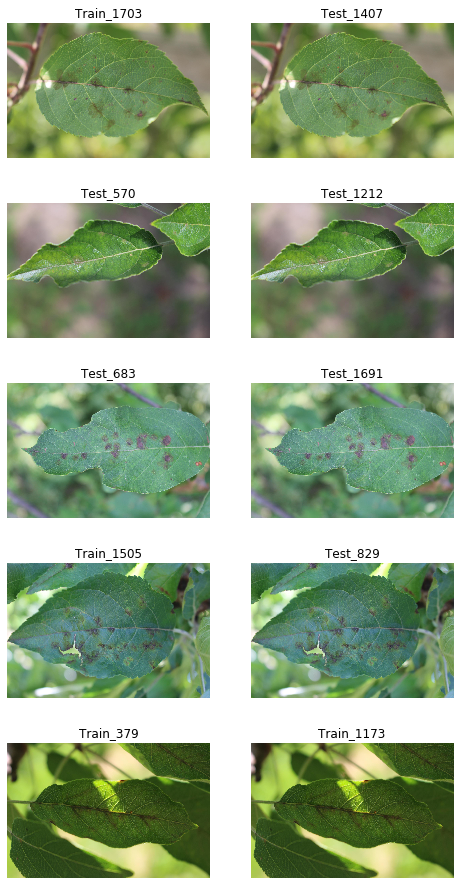

In [30]:
fig, ax = plt.subplots(5, 2, figsize=(8, 16))
ax = ax.flatten()

for i in range(0, min(duplicates.shape[0], 10), 2):
    image_i = cv2.imread(DIR_INPUT + '/images/{}.jpg'.format(duplicates.iloc[i, 2]), cv2.IMREAD_COLOR)
    image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
    ax[i].set_axis_off()
    ax[i].imshow(image_i)
    ax[i].set_title(duplicates.iloc[i, 2])
    
    image_i_1 = cv2.imread(DIR_INPUT + '/images/{}.jpg'.format(duplicates.iloc[i + 1, 2]), cv2.IMREAD_COLOR)
    image_i_1 = cv2.cvtColor(image_i_1, cv2.COLOR_BGR2RGB)
    ax[i + 1].set_axis_off()
    ax[i + 1].imshow(image_i_1)
    ax[i + 1].set_title(duplicates.iloc[i + 1, 2])

## [todo] fix train.csv

In [32]:
train_df[train_df['image_id'].isin(['Train_379','Train_1173'])]

image_id  healthy  multiple_diseases  rust  scab
379    Train_379        0                  0     0     1
1173  Train_1173        0                  1     0     0

In [45]:
def show_images(image_ids):
    
    col = 4
#     row = min(len(image_ids) // col, col)
    row = len(image_ids) // col + len(image_ids) % col

    
    fig, ax = plt.subplots(row, col, figsize=(16, 12))
    ax = ax.flatten()

    for i, image_id in enumerate(image_ids):
        image = cv2.imread(DIR_INPUT + '/images/{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_axis_off()
        ax[i].imshow(image)
        ax[i].set_title(image_id)

In [46]:
fig = go.Figure(data=[
    go.Pie(labels=train_df.columns[1:],
           values=train_df.iloc[:, 1:].sum().values)
])
fig.show()

# single classification

In [53]:
set(train_df.iloc[:,1:].sum(axis=1))

{1}

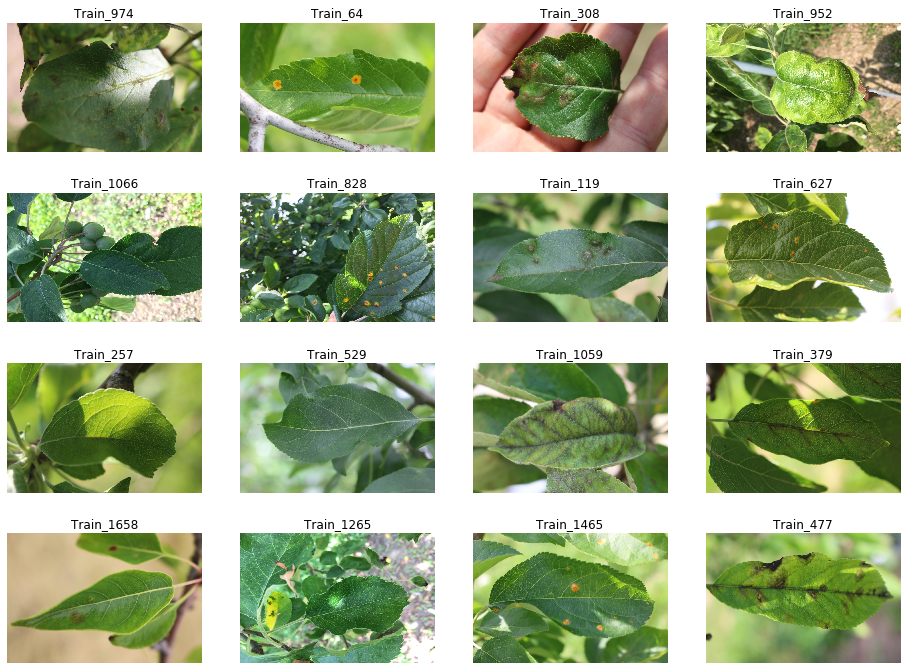

In [47]:
show_images(train_df.sample(n=16)['image_id'].values)

# 健康

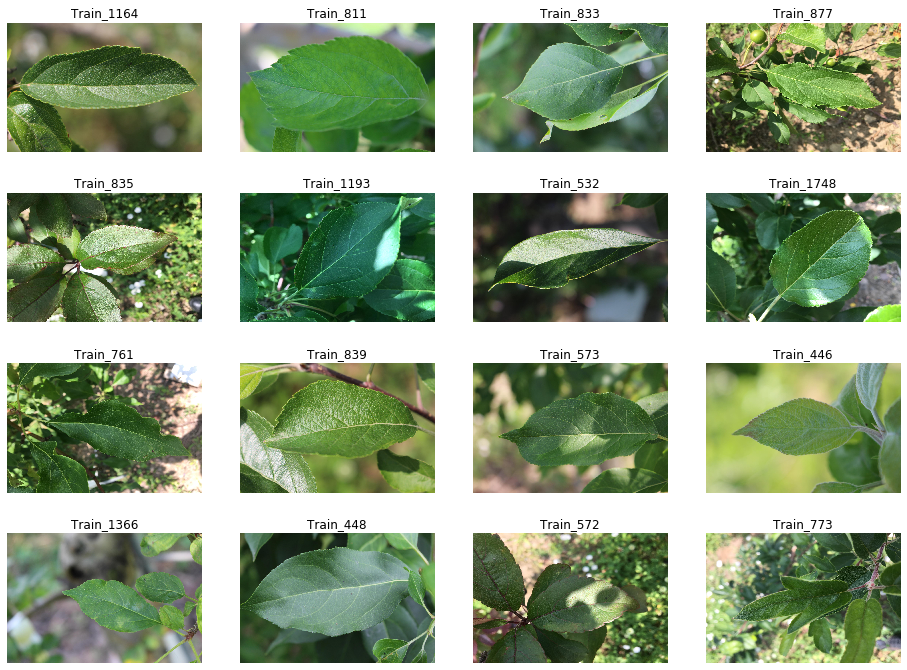

In [48]:
show_images(train_df[train_df['healthy'] == 1].sample(n=16)['image_id'].values)

# 锈病

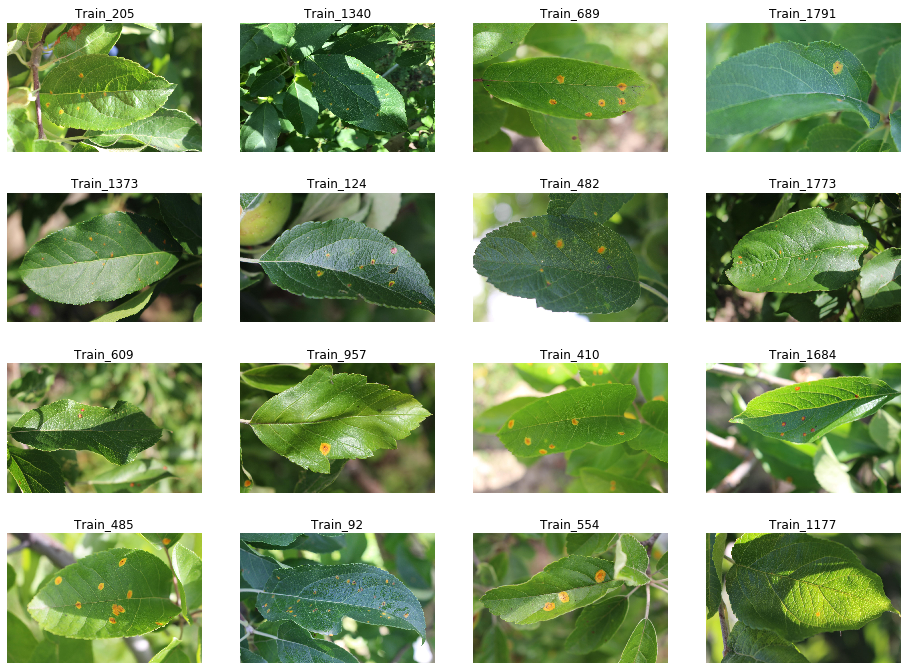

In [49]:
show_images(train_df[train_df['rust'] == 1].sample(n=16)['image_id'].values)

# 疮痂病，斑点病

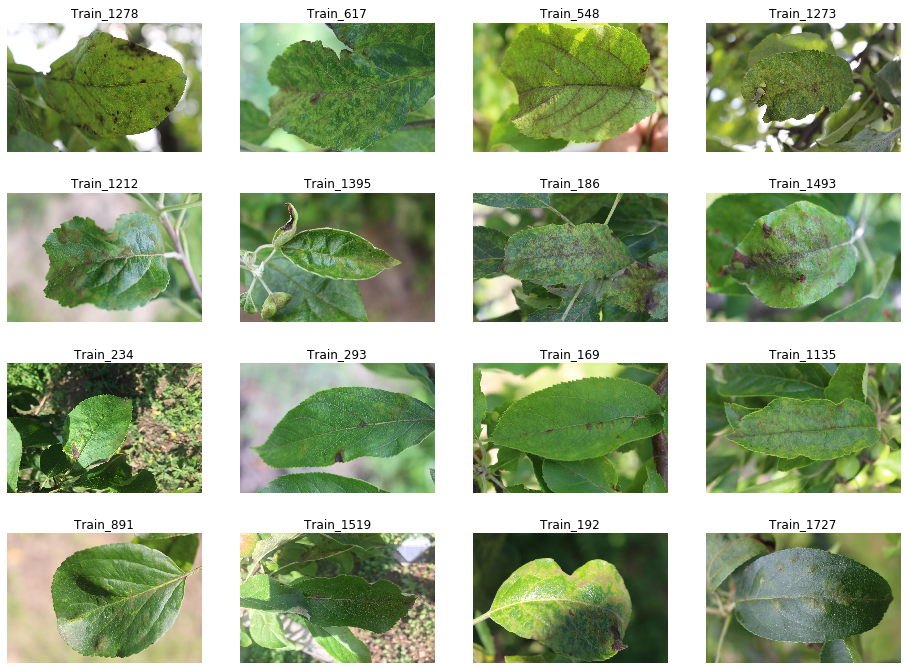

In [50]:
show_images(train_df[train_df['scab'] == 1].sample(n=16)['image_id'].values)

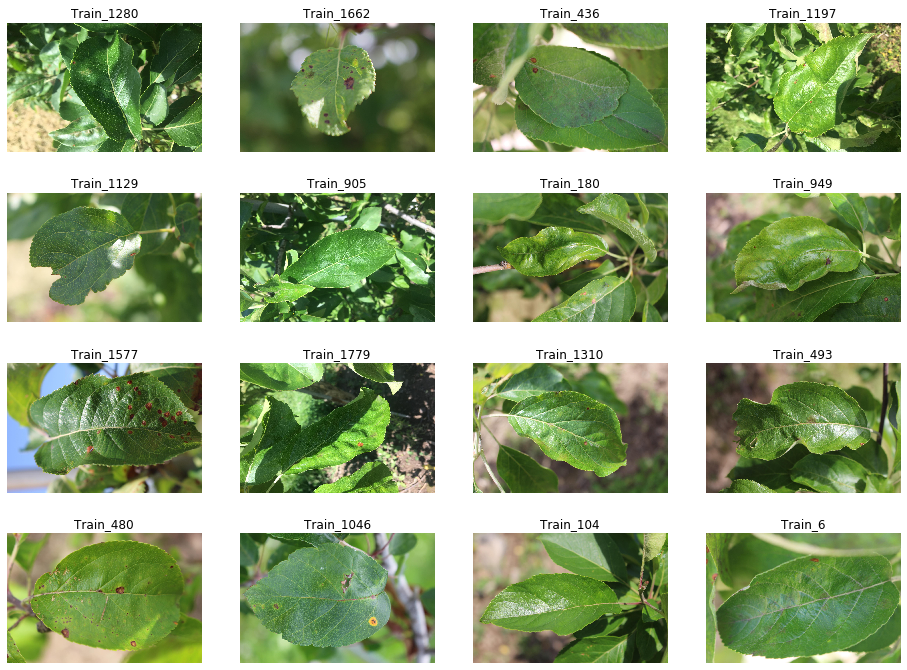

In [51]:
show_images(train_df[train_df['multiple_diseases'] == 1].sample(n=16)['image_id'].values)